<a href="https://colab.research.google.com/github/emarkou/multilingual-bert-text-classification/blob/master/mBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers

In [1]:
import time
import numpy as np
import pandas as pd

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertPreTrainedModel, BertModel
from transformers import get_linear_schedule_with_warmup

2024-05-04 13:11:32.646472: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 13:11:32.646558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 13:11:32.888472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

GPU in use: Tesla T4


In [4]:
MAX_LEN = 128 # max sequences length
batch_size = 32

In [5]:
# extra preprocessing steps
# prepend CLS and append SEP, truncate, pad

labels_encoding = {"negative":0,"positive":2,"neutral":1}

def preprocessing(df):
    sentences = df.review.values
    labels = np.array([labels_encoding[l] for l in df.sentiment.values])

    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

    encoded_sentences = []
    for sent in sentences:
        encoded_sent = tokenizer.encode(
                            sent,
                            add_special_tokens = True,
                            truncation=True,
                            max_length = MAX_LEN
                    )

        encoded_sentences.append(encoded_sent)
    encoded_sentences = pad_sequences(encoded_sentences, maxlen=MAX_LEN, dtype="long",
                            value=0, truncating="post", padding="post")
    return encoded_sentences, labels

def attention_masks(encoded_sentences):
    # attention masks, 0 for padding, 1 for actual token
    attention_masks = []
    for sent in encoded_sentences:
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)
    return attention_masks

In [6]:
# load the datasets
df = pd.read_csv("/kaggle/input/testytrainactsa/train.csv")
df_test = pd.read_csv("/kaggle/input/testytrainactsa/test.csv")
df=df.dropna()
df_test=df_test.dropna()

In [7]:
df.head()


,review,sentiment
0,"ఆర్డీఓ ఆయేషా మస్రత్ కా నం, తహసీల్దార్ కిషన్ ము...",neutral
1,ఈ సువిశాల భారతదేశంలో దాదాపు రెండుకోట్ల మంది వి...,neutral
2,జిల్లాలో శాంతి భద్రతలు అదుపులోనే ఉన్నాయన్నారు.,positive
3,"అలాగే, రెండవ ప్రపంచయుద్ధ కాలంనాటి పరిస్థితులను...",positive
4,"గతంలో ఎమ్మెల్యేలు, ఎం పీలు పర్యటనలు చేస్తే సమస...",negative


In [8]:
print(df.columns)


Index(['review', 'sentiment'], dtype='object')


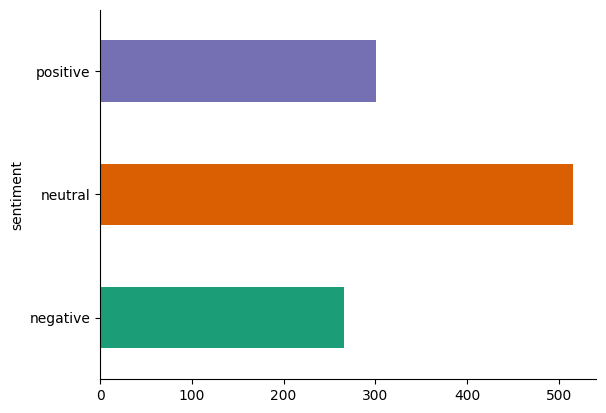

In [9]:
# @title target

from matplotlib import pyplot as plt
import seaborn as sns
df_test.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
train_encoded_sentences, train_labels = preprocessing(df)
train_attention_masks = attention_masks(train_encoded_sentences)

test_encoded_sentences, test_labels = preprocessing(df_test)
test_attention_masks = attention_masks(test_encoded_sentences)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [11]:
train_inputs = torch.tensor(train_encoded_sentences)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_attention_masks)

validation_inputs = torch.tensor(test_encoded_sentences)
validation_labels = torch.tensor(test_labels)
validation_masks = torch.tensor(test_attention_masks)

In [12]:
# data loader for training
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# data loader for validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [13]:

import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8,
                  weight_decay = 0.01
                )

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # 10% * datasetSize/batchSize
                                            num_training_steps = total_steps)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
import numpy as np
import torch
import time
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_accuracy(preds, labels):
    p = np.argmax(preds, axis=1).flatten()
    l = labels.flatten()
    return np.sum(p == l) / len(l)

def run_train(epochs):
    losses = []
    for e in range(epochs):
        print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
        start_train_time = time.time()
        total_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):

            if step % 10 == 0:
                elapsed = time.time() - start_train_time
                print(f'{step}/{len(train_dataloader)} --> Time elapsed {elapsed}')

            input_data = batch[0].to(device)
            input_masks = batch[1].to(device)
            input_labels = batch[2].to(device)

            model.zero_grad()

            out = model(input_data,
                        token_type_ids=None,
                        attention_mask=input_masks,
                        labels=input_labels)

            loss = out[0]
            total_loss = total_loss + loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            optimizer.step()

        epoch_loss = total_loss / len(train_dataloader)
        losses.append(epoch_loss)
        print(f"Training took {time.time() - start_train_time}")

        # Validation
        start_validation_time = time.time()
        model.eval()
        eval_loss, eval_acc = 0, 0
        y_true, y_pred = [], []
        for step, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            eval_data, eval_masks, eval_labels = batch
            with torch.no_grad():
                out = model(eval_data,
                            token_type_ids=None,
                            attention_mask=eval_masks)
            logits = out[0].detach().cpu().numpy()
            labels = eval_labels.cpu().numpy()
            batch_acc = compute_accuracy(logits, labels)
            eval_acc += batch_acc

            # Append true and predicted labels for computing F1, precision, and recall
            y_true.extend(labels)
            y_pred.extend(np.argmax(logits, axis=1))

        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"Accuracy: {eval_acc / (step + 1)}, Time elapsed: {time.time() - start_validation_time}")
        print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    return losses

# Run training
epochs = 5  # or any number of epochs you want
losses = run_train(epochs)


======== Epoch 1 / 5 ========
0/136 --> Time elapsed 0.014871358871459961
10/136 --> Time elapsed 7.705129623413086
20/136 --> Time elapsed 13.884328126907349
30/136 --> Time elapsed 20.135314464569092
40/136 --> Time elapsed 26.45368981361389
50/136 --> Time elapsed 32.82640314102173
60/136 --> Time elapsed 39.25962829589844
70/136 --> Time elapsed 45.76089930534363
80/136 --> Time elapsed 52.3235604763031
90/136 --> Time elapsed 58.97547912597656
100/136 --> Time elapsed 65.71631026268005
110/136 --> Time elapsed 72.55003905296326
120/136 --> Time elapsed 79.52596616744995
130/136 --> Time elapsed 86.58100748062134
Training took 90.38164854049683


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7538178733031674, Time elapsed: 7.850992441177368
Precision: 0.5687557443086501, Recall: 0.7541589648798521, F1 Score: 0.6484654534688719
======== Epoch 2 / 5 ========
0/136 --> Time elapsed 0.0022699832916259766
10/136 --> Time elapsed 6.816272020339966
20/136 --> Time elapsed 13.615664005279541
30/136 --> Time elapsed 20.355782747268677
40/136 --> Time elapsed 27.06892442703247
50/136 --> Time elapsed 33.80789279937744
60/136 --> Time elapsed 40.54586100578308
70/136 --> Time elapsed 47.3228964805603
80/136 --> Time elapsed 54.120591163635254
90/136 --> Time elapsed 60.93461632728577
100/136 --> Time elapsed 67.76196455955505
110/136 --> Time elapsed 74.58283424377441
120/136 --> Time elapsed 81.41851830482483
130/136 --> Time elapsed 88.23644542694092
Training took 91.86421871185303


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7538178733031674, Time elapsed: 7.46851110458374
Precision: 0.5687557443086501, Recall: 0.7541589648798521, F1 Score: 0.6484654534688719
======== Epoch 3 / 5 ========
0/136 --> Time elapsed 0.002294301986694336
10/136 --> Time elapsed 6.769902944564819
20/136 --> Time elapsed 13.55270266532898
30/136 --> Time elapsed 20.332805633544922
40/136 --> Time elapsed 27.108399391174316
50/136 --> Time elapsed 33.90767478942871
60/136 --> Time elapsed 40.687713384628296
70/136 --> Time elapsed 47.47644853591919
80/136 --> Time elapsed 54.27186942100525
90/136 --> Time elapsed 61.08145332336426
100/136 --> Time elapsed 67.88934683799744
110/136 --> Time elapsed 74.68305373191833
120/136 --> Time elapsed 81.48840928077698
130/136 --> Time elapsed 88.29459738731384
Training took 91.91492176055908


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7538178733031674, Time elapsed: 7.44740104675293
Precision: 0.5687557443086501, Recall: 0.7541589648798521, F1 Score: 0.6484654534688719
======== Epoch 4 / 5 ========
0/136 --> Time elapsed 0.0021543502807617188
10/136 --> Time elapsed 6.771115064620972
20/136 --> Time elapsed 13.572711706161499
30/136 --> Time elapsed 20.363009214401245
40/136 --> Time elapsed 27.14261269569397
50/136 --> Time elapsed 33.935203075408936
60/136 --> Time elapsed 40.70572328567505
70/136 --> Time elapsed 47.487528562545776
80/136 --> Time elapsed 54.27163743972778
90/136 --> Time elapsed 61.05753707885742
100/136 --> Time elapsed 67.85232472419739
110/136 --> Time elapsed 74.64198350906372
120/136 --> Time elapsed 81.45068550109863
130/136 --> Time elapsed 88.26573300361633
Training took 91.8997414112091


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7538178733031674, Time elapsed: 7.475456953048706
Precision: 0.5687557443086501, Recall: 0.7541589648798521, F1 Score: 0.6484654534688719
======== Epoch 5 / 5 ========
0/136 --> Time elapsed 0.002424001693725586
10/136 --> Time elapsed 6.811775207519531
20/136 --> Time elapsed 13.642807960510254
30/136 --> Time elapsed 20.465762615203857
40/136 --> Time elapsed 27.29313898086548
50/136 --> Time elapsed 34.14461946487427
60/136 --> Time elapsed 40.9654483795166
70/136 --> Time elapsed 47.79094314575195
80/136 --> Time elapsed 54.6221604347229
90/136 --> Time elapsed 61.45204281806946
100/136 --> Time elapsed 68.27742838859558
110/136 --> Time elapsed 75.1006691455841
120/136 --> Time elapsed 81.93610715866089
130/136 --> Time elapsed 88.76655101776123
Training took 92.40693306922913
Accuracy: 0.7528987556561086, Time elapsed: 7.475244760513306
Precision: 0.6792747237644936, Recall: 0.7532347504621072, F1 Score: 0.6547143866545911


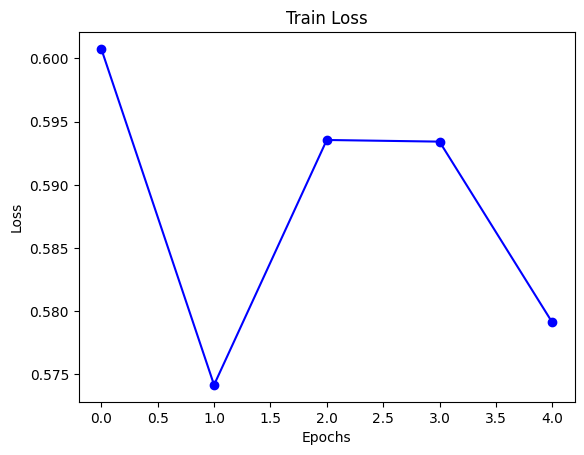

In [15]:
 # plot losses
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

plt.plot(losses, 'b-o')
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [16]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [17]:
def run_test(df_test):

    test_encoded_sentences, test_labels = preprocessing(df_test)
    test_attention_masks = attention_masks(test_encoded_sentences)

    test_inputs = torch.tensor(test_encoded_sentences)
    test_labels = torch.tensor(test_labels)
    test_masks = torch.tensor(test_attention_masks)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    model.eval()
    eval_loss, eval_acc = 0,0
    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        eval_data, eval_masks, eval_labels = batch
        with torch.no_grad():
            out = model(eval_data,
                        token_type_ids = None,
                        attention_mask=eval_masks)
        logits = out[0]
        logits = logits.detach().cpu().numpy()
        eval_labels = eval_labels.to('cpu').numpy()
        batch_acc = compute_accuracy(logits, eval_labels)
        eval_acc += batch_acc
    print(f"Accuracy: {eval_acc/(step+1)}")

In [18]:
run_test(df_test)

Accuracy: 0.7528987556561086
